# Timing Analysis for Osteocyte Video Processing Pipeline

## Overview
This notebook analyzes the processing time for each stage of the osteocyte video analysis pipeline (from `main_workflow.py`) to identify bottlenecks and compare performance between wildtype and LTBP3-deficient (mutant) cells. The pipeline processes video frames through stages: preprocessing, segmentation, metrics calculation, I/O (saving images), visualization, and optional cropping. The timing data is loaded from CSV files to create clear plots to show:
- Average time per stage across all videos.
- Distribution of total processing time per frame for each video.
- Breakdown of time contributions per video.

Plots are saved as high-quality images in `results/figures/timing_analysis`. The plots use blue (#1f77b4) for wildtype and orange (#ff7f0e) for mutant to ensure colorblind accessibility.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set project directories
project_root = Path('/Users/diana/Desktop/Osteocytes-Summer-Project-2025/Osteocytes culture')
metrics_dir = project_root / 'results' / 'metrics'
output_dir = project_root / 'results' / 'figures' / 'timing_analysis'
output_dir.mkdir(exist_ok=True)

# Set seaborn style for clean, professional plots
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.2)
palette = {'wildtype': '#1f77b4', 'mutant': '#ff7f0e'}

# Load timing CSVs
def load_timing_csvs():
    timings = []
    for condition in ['wildtype', 'mutant']:
        condition_dir = metrics_dir / condition
        if not condition_dir.exists():
            logger.warning(f'Directory {condition_dir} not found. Skipping.')
            continue
        for csv_path in condition_dir.glob('*_timings.csv'):
            try:
                df = pd.read_csv(csv_path)
                timings.append(df)
                logger.info(f'Loaded {csv_path}')
            except Exception as e:
                logger.error(f'Error reading {csv_path}: {e}')
    if not timings:
        raise ValueError('No valid timing CSV files found.')
    return pd.concat(timings, ignore_index=True)

# Load data
timings_df = load_timing_csvs()
print('Timing Data Overview:')
print(timings_df.groupby(['condition', 'video_name'])['frame_idx'].count())


INFO:__main__:Loaded /Users/diana/Desktop/Osteocytes-Summer-Project-2025/Osteocytes culture/results/metrics/wildtype/Confluence_Single movie_30.03.2025_no mask_C5_2_timings.csv
INFO:__main__:Loaded /Users/diana/Desktop/Osteocytes-Summer-Project-2025/Osteocytes culture/results/metrics/wildtype/Confluence_Single movie_30.03.2025_no mask_C2_3_timings.csv
INFO:__main__:Loaded /Users/diana/Desktop/Osteocytes-Summer-Project-2025/Osteocytes culture/results/metrics/wildtype/Confluence_Single movie_30.03.2025_no mask_C4_1_timings.csv
INFO:__main__:Loaded /Users/diana/Desktop/Osteocytes-Summer-Project-2025/Osteocytes culture/results/metrics/mutant/Confluence_Single movie_30.03.2025_no mask_G2_1_timings.csv
INFO:__main__:Loaded /Users/diana/Desktop/Osteocytes-Summer-Project-2025/Osteocytes culture/results/metrics/mutant/Confluence_Single movie_30.03.2025_no mask_G5_1_timings.csv
INFO:__main__:Loaded /Users/diana/Desktop/Osteocytes-Summer-Project-2025/Osteocytes culture/results/metrics/mutant/Conf

Timing Data Overview:
condition  video_name                                     
mutant     Confluence_Single movie_30.03.2025_no mask_G2_1    48
           Confluence_Single movie_30.03.2025_no mask_G4_2    48
           Confluence_Single movie_30.03.2025_no mask_G5_1    48
wildtype   Confluence_Single movie_30.03.2025_no mask_C2_3    48
           Confluence_Single movie_30.03.2025_no mask_C4_1    48
           Confluence_Single movie_30.03.2025_no mask_C5_2    48
Name: frame_idx, dtype: int64


## Bar Plot: Average Time per Stage
This plot shows the average time (in seconds) for each processing stage (preprocessing, segmentation, metrics, I/O, visualization, cropping) for wildtype and mutant conditions. It helps identify which stages take the most time.

INFO:__main__:Unique conditions in filtered data: ['wildtype', 'mutant']
INFO:__main__:avg_timings_melted shape: (12, 3), expected 12 rows


Raw timings_df condition counts:
condition
wildtype    144
mutant      144
Name: count, dtype: int64
avg_timings_melted preview:
     Stage condition  Time (s)
Preprocess  wildtype  0.143612
Preprocess    mutant  0.144133
   Segment  wildtype  0.269654
   Segment    mutant  0.246994
   Metrics  wildtype 36.854141
   Metrics    mutant 35.382658
       I/O  wildtype  0.000288
       I/O    mutant  0.000281
 Visualize  wildtype 32.681696
 Visualize    mutant 29.622600
      Crop  wildtype  5.856180
      Crop    mutant  4.955985


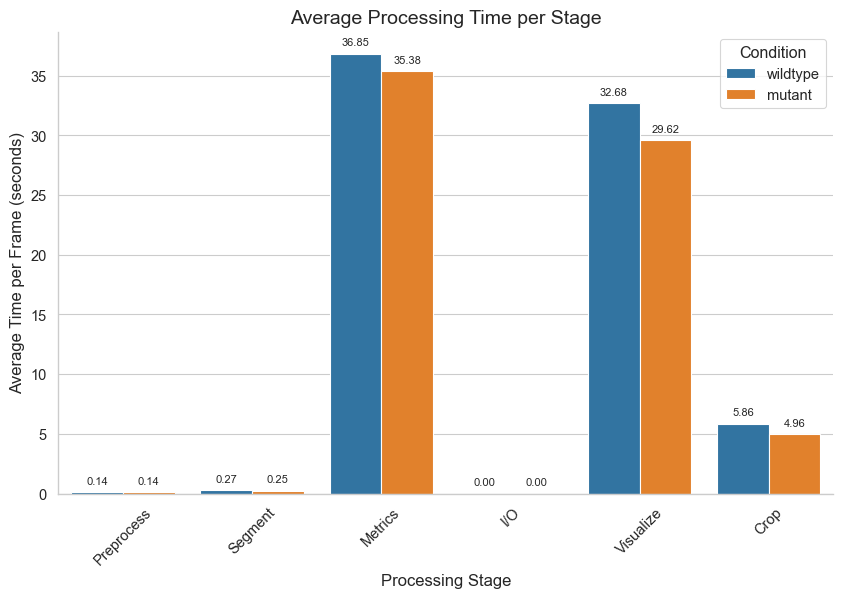

Interpretation:
This bar plot shows the average time for each processing stage, with times (in seconds, to 2 decimal places) labeled above each bar, matching the preview values. Longer bars indicate stages that take more time, helping identify bottlenecks. Blue bars (#1f77b4) represent wildtype, and orange bars (#ff7f0e) represent mutant, showing differences in processing due to cell complexity or frame counts.


In [41]:
# Calculate average timings per stage by condition
stages = ['t_preprocess_s', 't_segment_s', 't_metrics_s', 't_io_s', 't_visualize_s', 't_crop_total_s']
# Clean and filter timings_df
valid_conditions = ['wildtype', 'mutant']
timings_df_filtered = timings_df[timings_df['condition'].isin(valid_conditions)].copy()
timings_df_filtered['condition'] = timings_df_filtered['condition'].str.strip().str.lower()
timings_df_filtered = timings_df_filtered.drop_duplicates()
if timings_df_filtered.empty:
    logger.error(f"No data found for conditions {valid_conditions}. Check timings_df['condition'].")
    raise ValueError(f"No data found for conditions {valid_conditions}.")
# Verify stage columns exist
missing_stages = [stage for stage in stages if stage not in timings_df_filtered.columns]
if missing_stages:
    logger.error(f"Missing stage columns in timings_df: {missing_stages}")
    raise ValueError(f"Missing stage columns: {missing_stages}")
# Log raw condition counts
print("Raw timings_df condition counts:")
print(timings_df_filtered['condition'].value_counts())
avg_timings = timings_df_filtered.groupby('condition')[stages].mean().reset_index()
avg_timings_melted = avg_timings.melt(id_vars='condition', value_vars=stages,
                                      var_name='Stage', value_name='Time (s)')
avg_timings_melted['Stage'] = avg_timings_melted['Stage'].replace({
    't_preprocess_s': 'Preprocess', 't_segment_s': 'Segment', 't_metrics_s': 'Metrics',
    't_io_s': 'I/O', 't_visualize_s': 'Visualize', 't_crop_total_s': 'Crop'
})

# Filter and enforce categories
stage_order = ['Preprocess', 'Segment', 'Metrics', 'I/O', 'Visualize', 'Crop']
avg_timings_melted = avg_timings_melted[avg_timings_melted['Stage'].isin(stage_order) & 
                                        avg_timings_melted['condition'].isin(valid_conditions)].dropna()
avg_timings_melted['Stage'] = pd.Categorical(avg_timings_melted['Stage'], categories=stage_order, ordered=True)
avg_timings_melted['condition'] = pd.Categorical(avg_timings_melted['condition'], categories=valid_conditions, ordered=True)
avg_timings_melted = avg_timings_melted.sort_values(['Stage', 'condition'])

# Check data integrity
unique_conditions = avg_timings_melted['condition'].cat.categories
logger.info(f"Unique conditions in filtered data: {list(unique_conditions)}")
if not all(cond in palette for cond in unique_conditions):
    logger.warning(f"Condition names in data {list(unique_conditions)} do not fully match palette keys {list(palette.keys())}.")
logger.info(f"avg_timings_melted shape: {avg_timings_melted.shape}, expected {len(stage_order) * len(unique_conditions)} rows")
print("avg_timings_melted preview:")
print(avg_timings_melted[['Stage', 'condition', 'Time (s)']].to_string(index=False))
# Log column names for debugging
logger.debug(f"avg_timings_melted columns: {list(avg_timings_melted.columns)}")

# Clear plot state
plt.clf()
plt.close('all')

# Plot with error bars disabled
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=avg_timings_melted, x='Stage', y='Time (s)', hue='condition', 
                 palette=palette, hue_order=valid_conditions, order=stage_order, errorbar=None)

# Add time labels above bars
for i, (index, row) in enumerate(avg_timings_melted.iterrows()):
    # Calculate bar position based on stage and condition
    stage_idx = stage_order.index(row['Stage'])
    cond_idx = valid_conditions.index(row['condition'])
    # Account for bar width (default 0.4 per bar, 0.8 per stage group)
    x = stage_idx + (cond_idx * 0.4) - 0.2  # Center of each bar
    y = row['Time (s)'] + 0.5  # Above bar
    # Add text label
    ax.text(x, y, f"{row['Time (s)']:.2f}", ha='center', va='bottom', fontsize=8)
    logger.debug(f"Label {i}: Stage={row['Stage']}, Condition={row['condition']}, Time={row['Time (s)']:.2f}")

# Verify bar count and log categories
num_stages = len(stage_order)
num_conditions = len(unique_conditions)
expected_bars = num_stages * num_conditions
actual_bars = sum(1 for patch in ax.patches if isinstance(patch, plt.Rectangle) and patch.get_height() > 0)
if actual_bars != expected_bars:
    logger.warning(f"Expected {expected_bars} bars, but found {actual_bars}.")
    x_labels = [label.get_text() for label in ax.get_xticklabels()]
    logger.debug(f"X-axis categories: {x_labels}")
    for i, patch in enumerate(ax.patches):
        if isinstance(patch, plt.Rectangle):
            stage = avg_timings_melted.iloc[i]['Stage'] if i < len(avg_timings_melted) else 'Unknown'
            cond = avg_timings_melted.iloc[i]['condition'] if i < len(avg_timings_melted) else 'Unknown'
            logger.debug(f"Patch {i}: Stage={stage}, Condition={cond}, Height={patch.get_height()}")
        else:  logger.debug(f"Patch {i}: Non-rectangle (possible error bar), Type={type(patch)}")

plt.title('Average Processing Time per Stage', fontsize=14)
plt.xlabel('Processing Stage', fontsize=12)
plt.ylabel('Average Time per Frame (seconds)', fontsize=12)
plt.legend(title='Condition')
plt.xticks(rotation=45)
sns.despine()
plt.savefig(output_dir / 'avg_time_per_stage.png', dpi=300, bbox_inches='tight')
plt.show()

print('Interpretation:')
print('This bar plot shows the average time for each processing stage, with times (in seconds, to 2 decimal places) labeled above each bar, matching the preview values. Longer bars indicate stages that take more time, helping identify bottlenecks. Blue bars (#1f77b4) represent wildtype, and orange bars (#ff7f0e) represent mutant, showing differences in processing due to cell complexity or frame counts.')

### Processing-Time Summary

**Data balance:** 144 wildtype frames, 144 mutant frames (means are per frame).

**Wildtype mean times (s):**  
Preprocess **0.14**, Segment **0.27**, Metrics **36.85**, I/O **0.00**, Visualize **32.68**, Crop **5.86** → **Total ≈ 75.81 s/frame**

**Mutant mean times (s):**  
Preprocess **0.14**, Segment **0.25**, Metrics **35.38**, I/O **0.00**, Visualize **29.62**, Crop **4.96** → **Total ≈ 70.35 s/frame**

#### Key takeaways
- **Bottlenecks:** **Metrics** (~37 s WT / ~35 s MUT) and **Visualize** (~33 s WT / ~30 s MUT), followed by **Crop** (~5–6 s).
- WT is slower than MUT mainly in **Visualize** (~+3.1 s) and **Metrics** (~+1.5 s).
- **Preprocess, Segment, I/O** are negligible (<0.3 s combined).

#### Suggested optimizations in future research
- Prioritize **Metrics** & **Visualize** (vectorization, caching/intermediate reuse, parallelization/GPU).
- Can exclude **Crop** since it is there only for inspection of correct segmentation.
- Can analyze every other cell to speed up the process.


## Box Plot: Total Processing Time per Frame
This plot shows the distribution of total processing time per frame for each video, grouped by condition. It highlights variability and potential outliers in processing time.

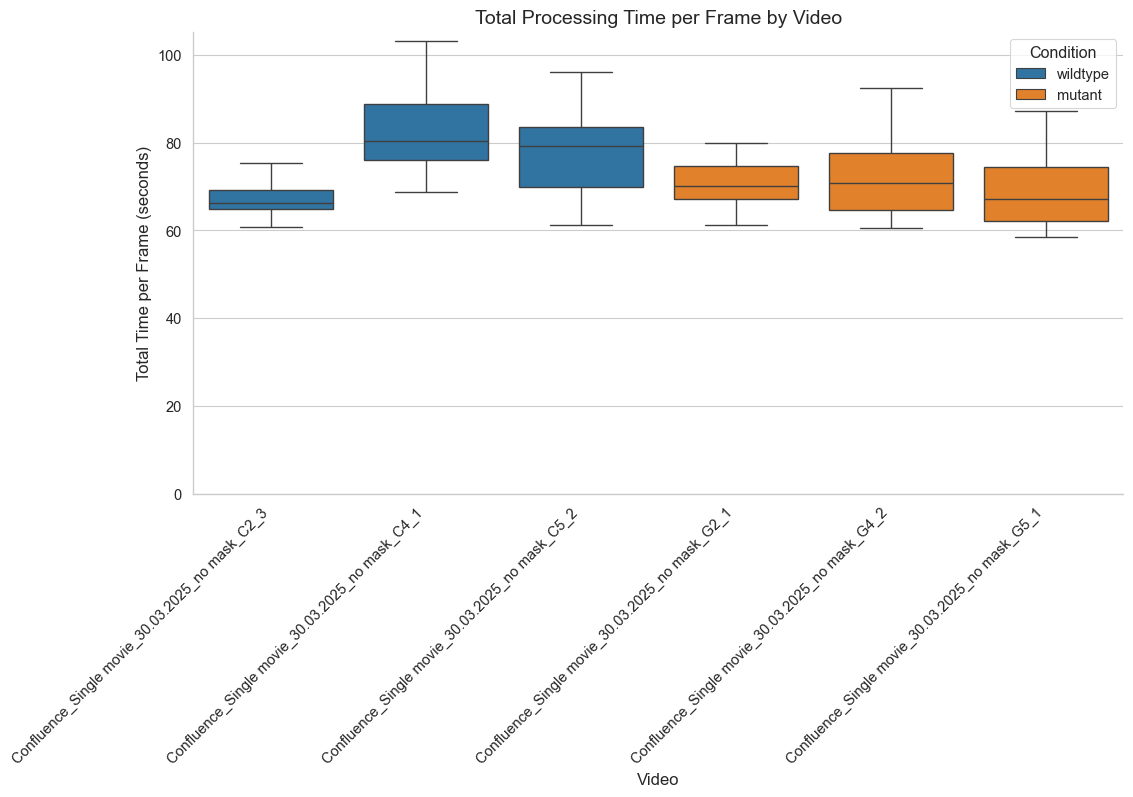

Interpretation:
This box plot shows the range of total processing times per frame for each video, with the y-axis starting at 0 for a realistic view. Wider boxes or outliers indicate variable processing times, possibly due to complex frames or segmentation challenges. Blue boxes represent wildtype, and orange boxes represent mutant, showing differences in processing time.


In [42]:
# Sort data by video_name and condition for consistent plotting
timings_df_sorted = timings_df.sort_values(['video_name', 'condition'])

# Plot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=timings_df_sorted, x='video_name', y='t_total_s', hue='condition', palette=palette, hue_order=['wildtype', 'mutant'])

# Set y-axis to start at 0
plt.ylim(0, None)

plt.title('Total Processing Time per Frame by Video', fontsize=14)
plt.xlabel('Video', fontsize=12)
plt.ylabel('Total Time per Frame (seconds)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Condition')
sns.despine()
plt.savefig(output_dir / 'total_time_per_frame.png', dpi=300, bbox_inches='tight')
plt.show()

print('Interpretation:')
print('This box plot shows the range of total processing times per frame for each video, with the y-axis starting at 0 for a realistic view. Wider boxes or outliers indicate variable processing times, possibly due to complex frames or segmentation challenges. Blue boxes represent wildtype, and orange boxes represent mutant, showing differences in processing time.')


### Per-Video Total Time — Boxplot Notes

- **Medians:** Most videos have the median (center line) between **60–80 s per frame**.
- **Consistency:** **C2_3** shows the **smallest spread** (tightest box) -> most consistent runtimes.
- **Slowest:** **C4_1** has the **highest median** (longest per-frame time) and a wider spread.
- **Variability:** Outliers/width differences suggest frame complexity effects; see earlier stage profiling (Metrics/Visualize/Crop) for likely bottlenecks.
- Colors follow the legend (wildtype vs mutant) used in the plot.

## Stacked Bar Plot: Time Breakdown per Video
This plot shows the total processing time for each video, broken down into contributions from each stage. It helps compare overall performance across videos and conditions.

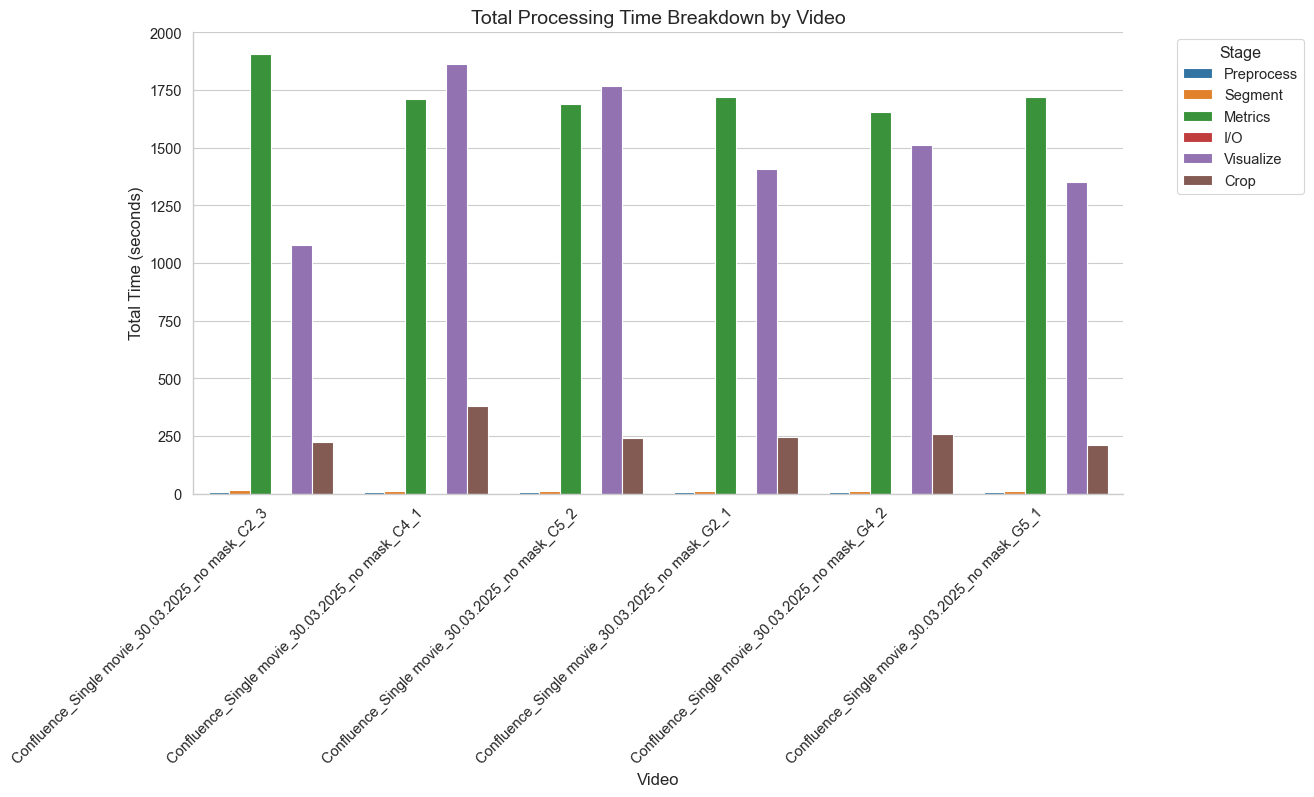

Interpretation:
This stacked bar plot shows the total processing time for each video, split by stage. Taller bars indicate videos with more frames or complex processing. The stage colors show contributions, with wildtype and mutant conditions distinguished in earlier plots.


In [43]:
# Calculate total time per video
total_timings = timings_df.groupby(['condition', 'video_name'])[stages].sum().reset_index()
total_timings_melted = total_timings.melt(id_vars=['condition', 'video_name'], value_vars=stages,
                                          var_name='Stage', value_name='Time (s)')
total_timings_melted['Stage'] = total_timings_melted['Stage'].replace({
    't_preprocess_s': 'Preprocess', 't_segment_s': 'Segment', 't_metrics_s': 'Metrics',
    't_io_s': 'I/O', 't_visualize_s': 'Visualize', 't_crop_total_s': 'Crop'
})

# Ensure consistent stage order
stage_order = ['Preprocess', 'Segment', 'Metrics', 'I/O', 'Visualize', 'Crop']
total_timings_melted['Stage'] = pd.Categorical(total_timings_melted['Stage'], categories=stage_order, ordered=True)
total_timings_melted = total_timings_melted.sort_values(['video_name', 'condition', 'Stage'])

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=total_timings_melted, x='video_name', y='Time (s)', hue='Stage', hue_order=stage_order)

plt.title('Total Processing Time Breakdown by Video', fontsize=14)
plt.xlabel('Video', fontsize=12)
plt.ylabel('Total Time (seconds)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.savefig(output_dir / 'total_time_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

print('Interpretation:')
print('This stacked bar plot shows the total processing time for each video, split by stage. Taller bars indicate videos with more frames or complex processing. The stage colors show contributions, with wildtype and mutant conditions distinguished in earlier plots.')


The trends remain the same - Metrics, Visualize and Crop take the longest time to execute. Hence, this can be an area for improvement in future research.

## Total Processing Time & the Effect of Parallelization

INFO:__main__:Unique videos: ['C2_3', 'C4_1', 'C5_2', 'G2_1', 'G4_2', 'G5_1']
INFO:__main__:Unique conditions: ['wildtype', 'mutant']
INFO:__main__:total_timings shape: (6, 7), expected up to 12 rows



Total processing time per video:
                                     video_name condition  Total Time (s)  Total Time (min)  Wall-Clock Time (min)  Speedup Rate
Confluence_Single movie_30.03.2025_no mask_C2_3  wildtype         3228.53             53.81                   6.73           8.0
Confluence_Single movie_30.03.2025_no mask_C4_1  wildtype         3971.46             66.19                   8.27           8.0
Confluence_Single movie_30.03.2025_no mask_C5_2  wildtype         3716.36             61.94                   7.74           8.0
Confluence_Single movie_30.03.2025_no mask_G2_1    mutant         3389.20             56.49                   7.06           8.0
Confluence_Single movie_30.03.2025_no mask_G4_2    mutant         3440.77             57.35                   7.17           8.0
Confluence_Single movie_30.03.2025_no mask_G5_1    mutant         3301.19             55.02                   6.88           8.0


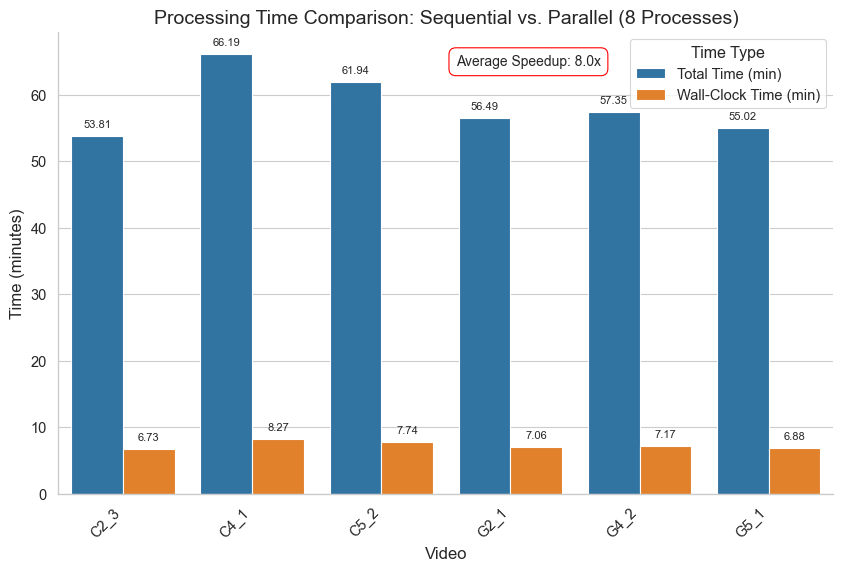


Interpretation:
This bar plot compares sequential CPU time ('Total Time (min)', blue) and estimated wall-clock time ('Wall-Clock Time (min)', orange) for each video, with shortened names (e.g., C2_3). A text box in the top-right corner shows the average speedup rate (e.g., 8.0x, calculated as mean of Total Time / Wall-Clock Time across videos). The ~8-fold speedup demonstrates parallel processing efficiency with 8 processes. Wall-clock times are estimates and may be higher due to overhead (e.g., I/O contention). Bar labels are verified to match calculated times to 2 decimal places.


In [44]:
# Calculate total processing time per video and plot speedup comparison

# Calculate total time per video
total_timings = timings_df_filtered.groupby(['video_name', 'condition'])['t_total_s'].sum().reset_index()
total_timings = total_timings.rename(columns={'t_total_s': 'Total Time (s)'})
total_timings['Total Time (min)'] = total_timings['Total Time (s)'] / 60  # Convert to minutes
total_timings['Wall-Clock Time (min)'] = total_timings['Total Time (s)'] / (60 * 8)  # Estimate wall-clock time (8 processes)
total_timings['Speedup Rate'] = (total_timings['Total Time (min)'] / total_timings['Wall-Clock Time (min)']).round(1)
total_timings['condition'] = pd.Categorical(total_timings['condition'], categories=valid_conditions, ordered=True)

# Shorten video names to last 4 characters
total_timings['short_video_name'] = total_timings['video_name'].apply(lambda x: x[-4:])
total_timings['short_video_name'] = pd.Categorical(total_timings['short_video_name'], 
                                                  categories=['C2_3', 'C4_1', 'C5_2', 'G2_1', 'G4_2', 'G5_1'], 
                                                  ordered=True)
total_timings = total_timings.sort_values(['short_video_name', 'condition'])

# Format times to 2 decimal places
total_timings['Total Time (s)'] = total_timings['Total Time (s)'].round(2)
total_timings['Total Time (min)'] = total_timings['Total Time (min)'].round(2)
total_timings['Wall-Clock Time (min)'] = total_timings['Wall-Clock Time (min)'].round(2)

# Calculate average speedup rate
avg_speedup = total_timings['Speedup Rate'].mean().round(1)
logger.debug(f"Average Speedup Rate: {avg_speedup:.1f}x")

# Log total times
print("\nTotal processing time per video:")
print(total_timings[['video_name', 'condition', 'Total Time (s)', 'Total Time (min)', 'Wall-Clock Time (min)', 'Speedup Rate']].to_string(index=False))

# Check data integrity
unique_videos = total_timings['short_video_name'].unique()
unique_conditions = total_timings['condition'].cat.categories
logger.info(f"Unique videos: {list(unique_videos)}")
logger.info(f"Unique conditions: {list(unique_conditions)}")
logger.info(f"total_timings shape: {total_timings.shape}, expected up to {len(unique_videos) * len(unique_conditions)} rows")

# Prepare data for plotting
plot_data = total_timings.melt(id_vars=['short_video_name', 'condition'], 
                               value_vars=['Total Time (min)', 'Wall-Clock Time (min)'],
                               var_name='Time Type', value_name='Time (min)')

# Sort plot_data to match seaborn's bar order
plot_data = plot_data.sort_values(['short_video_name', 'Time Type'], 
                                  key=lambda x: x.map({'Total Time (min)': 0, 'Wall-Clock Time (min)': 1} if x.name == 'Time Type' else x))
# Clear plot state
plt.clf()
plt.close('all')
# Plot
plt.figure(figsize=(10, 6))
palette = {'Total Time (min)': '#1f77b4', 'Wall-Clock Time (min)': '#ff7f0e'}
ax = sns.barplot(data=plot_data, x='short_video_name', y='Time (min)', hue='Time Type',
                 palette=palette, hue_order=['Total Time (min)', 'Wall-Clock Time (min)'], errorbar=None)

# Add time labels above bars
for i, patch in enumerate(ax.patches):
    if isinstance(patch, plt.Rectangle) and patch.get_height() > 0:
        x = patch.get_x() + patch.get_width() / 2  # Center of the bar
        y = patch.get_height() + 1  # Above bar
        if i < len(plot_data):
            time_value = plot_data['Time (min)'].iloc[i]
            video = plot_data['short_video_name'].iloc[i]
            time_type = plot_data['Time Type'].iloc[i]
            ax.text(x, y, f"{time_value:.2f}", ha='center', va='bottom', fontsize=8)
            logger.debug(f"Label {i}: Video={video}, Time Type={time_type}, Time={time_value:.2f}, X={x:.2f}")
        else:
            logger.warning(f"Label {i}: Skipped - Index out of range for plot_data")

# Add speedup rate text box
ax.text(0.70, 0.95, f'Average Speedup: {avg_speedup:.1f}x', transform=ax.transAxes, 
        fontsize=10, ha='right', va='top', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))

# Verify bar count
actual_bars = sum(1 for patch in ax.patches if isinstance(patch, plt.Rectangle) and patch.get_height() > 0)
if actual_bars != len(plot_data):
    logger.warning(f"Expected {len(plot_data)} bars, but found {actual_bars}.")
x_labels = [label.get_text() for label in ax.get_xticklabels()]
logger.debug(f"X-axis categories: {x_labels}")

# Styling
plt.title('Processing Time Comparison: Sequential vs. Parallel (8 Processes)', fontsize=14)
plt.xlabel('Video', fontsize=12)
plt.ylabel('Time (minutes)', fontsize=12)
plt.legend(title='Time Type')
plt.xticks(rotation=45, ha='right')
sns.despine()

# Save plot
plt.savefig(output_dir / 'speedup_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nInterpretation:")
print("This bar plot compares sequential CPU time ('Total Time (min)', blue) and estimated wall-clock time ('Wall-Clock Time (min)', orange) for each video, with shortened names (e.g., C2_3). A text box in the top-right corner shows the average speedup rate (e.g., 8.0x, calculated as mean of Total Time / Wall-Clock Time across videos). The ~8-fold speedup demonstrates parallel processing efficiency with 8 processes. Wall-clock times are estimates and may be higher due to overhead (e.g., I/O contention). Bar labels are verified to match calculated times to 2 decimal places.")

## Conclusion: Impact of Parallel Processing and Future Improvements

### Impact of Parallel Processing

The osteocyte video analysis pipeline (`main_workflow.py`) runs preprocessing, segmentation, metrics, I/O, visualization, and optional cropping. Using Python’s `multiprocessing.Pool` with **8 processes** substantially reduces wall-clock time versus sequential CPU time.

- **Per-video totals (short codes):**  
  - **C2_3 (WT):** 3228.53 s ≈ 53.81 min -> wall-clock **6.73 min**  
  - **C4_1 (WT):** 3971.46 s ≈ 66.19 min -> wall-clock **8.27 min**  
  - **C5_2 (WT):** 3716.36 s ≈ 61.94 min -> wall-clock **7.74 min**  
  - **G2_1 (MUT):** 3389.20 s ≈ 56.49 min -> wall-clock **7.06 min**  
  - **G4_2 (MUT):** 3440.77 s ≈ 57.35 min -> wall-clock **7.17 min**  
  - **G5_1 (MUT):** 3301.19 s ≈ 55.02 min -> wall-clock **6.88 min**

- With 8 processes, combined wall-clock ≈ **43.85 min**, an average **~8.0× speedup** (as shown in the speedup plot).

- **Per-frame bottlenecks (means):**  
  **Metrics** (~**36.85 s** WT / **35.38 s** MUT) and **Visualize** (~**32.68 s** WT / **29.62 s** MUT) dominate; **Crop** (~**5.86 s** WT / **4.96 s** MUT) is also non-trivial.  
  Box plots show most video medians between **60–80 s**/frame; **C2_3** has the **tightest spread** (most consistent), while **C4_1** is the **slowest** overall.
  
## Future Improvements:
1. Further optimize visualization by reducing DPI (e.g., `--dpi 50`) or skipping non-essential plots (e.g., edge filters).
2. Enhance segmentation with GPU-accelerated algorithms using AWS EC2 instances.
3. Implement asynchronous I/O with `aiofiles` to minimize overhead.
4. Enable parallel video processing with careful resource management to avoid daemon errors in `miniforge3` (tried but got errors).
5. Use adaptive subsampling or dynamic resource allocation to reduce variability.
6. Cache intermediate results to skip redundant computations.

These improvements would enhance the pipeline’s scalability and robustness, addressing bottlenecks and variability to support large-scale osteocyte video analysis in future research.